# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import precision_score, accuracy_score, classification_report, roc_curve

In [2]:
data = pd.read_csv('data/spam_or_not_spam.zip')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

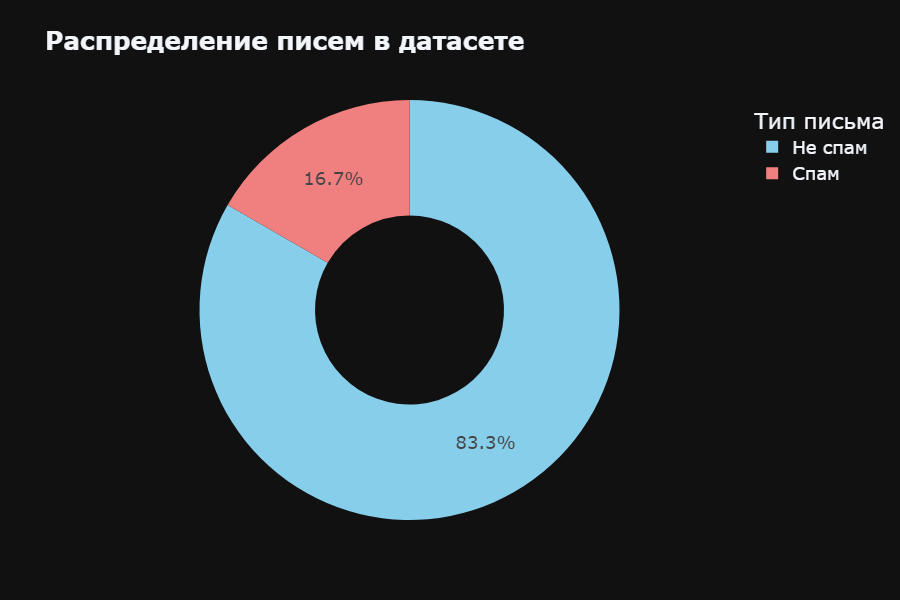

In [4]:
count_df = pd.DataFrame(data['label'].apply(lambda label: 'Спам' if label else 'Не спам').value_counts()).reset_index()
count_df = count_df.rename(columns=dict(index='Тип письма', label='Количество в датасете'))

count_bar = px.pie(
    data_frame=count_df,
    names='Тип письма',
    values='Количество в датасете',
    template='plotly_dark',
    width=900,
    height=600,
    title='<b>Распределение писем в датасете</b>',
    color_discrete_sequence=['SkyBlue', 'LightCoral'],
    hole=0.45
).update_layout(font=dict(size=18), legend_title='Тип письма')

count_bar.show('png')

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
data['email'] = data['email'].fillna(np.nan).replace(r'^\s+$', np.nan, regex=True)
data.dropna(axis='index', how='any', inplace=True)
print(f'Количество строк после очистки данных от пропусков: {data.shape[0]}')

Количество строк после очистки данных от пропусков: 2997


Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
print(f'Количество признаков после использования CountVectorizer: {X.shape[1]}')

Количество признаков после использования CountVectorizer: 34116


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
y_test.mean().round(3)

0.165

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [12]:
compl_nb = ComplementNB(alpha=0.01).fit(X_train, y_train)
y_test_pred = compl_nb.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
print(
    f'Accuracy: {accuracy_test}',
    f'\nPrecision: {precision_test}'
)

Accuracy: 0.988 
Precision: 1.0


Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [13]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       626
           1       1.00      0.93      0.96       124

    accuracy                           0.99       750
   macro avg       0.99      0.96      0.98       750
weighted avg       0.99      0.99      0.99       750



Нарисуйте ROC-кривую:

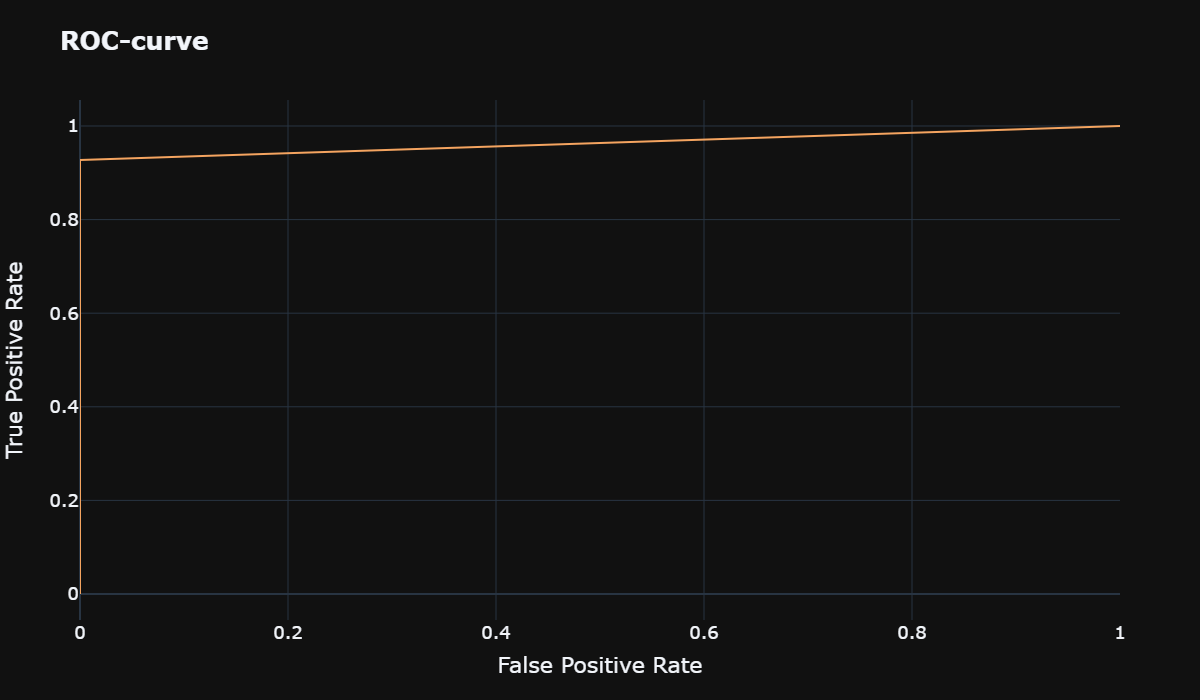

In [14]:
fpr, trp, _ = roc_curve(y_test, y_test_pred)
roc_curve_plot = px.line(
    x=fpr,
    y=trp,
    title='<b>ROC-curve</b>',
    labels=dict(y='True Positive Rate', x='False Positive Rate'),
    template='plotly_dark',
    width=1200,
    height=700,
    color_discrete_sequence=['SandyBrown']
).update_layout(font=dict(size=18))
roc_curve_plot.show('png')

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

Fitting 5 folds for each of 100 candidates, totalling 500 fits


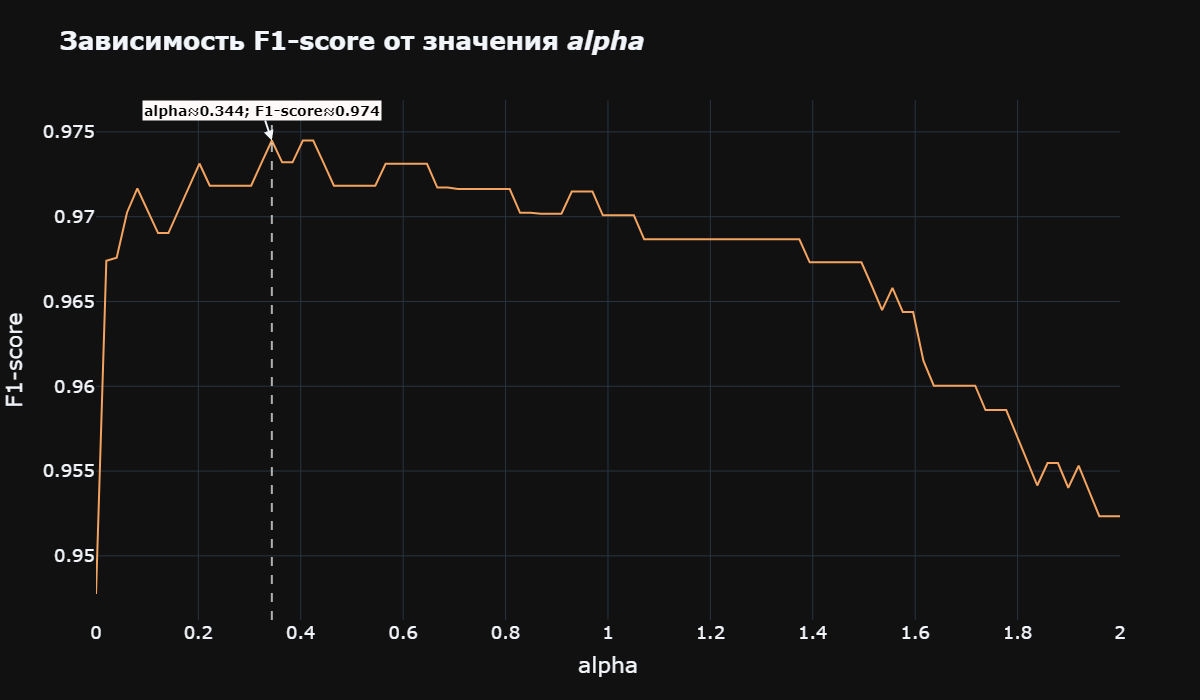

In [15]:
params = dict(alpha=np.linspace(1e-4, 2, 100))
compl_nb_cv = GridSearchCV(
    estimator=ComplementNB(),
    param_grid=params,
    n_jobs=-1,
    scoring='f1',
    cv=5,
    verbose=1,
)
compl_nb_cv.fit(X_train, y_train)
f1_array = compl_nb_cv.cv_results_['mean_test_score']
best_alpha = compl_nb_cv.best_params_['alpha']

f1_line = px.line(
    x=params['alpha'],
    y=f1_array,
    width=1200,
    height=700,
    template='plotly_dark',
    labels=dict(x='alpha', y='F1-score'),
    title='<b>Зависимость F1-score от значения <i>alpha</i></b>',
    color_discrete_sequence=['SandyBrown']
).add_vline(
    x=best_alpha,
    line_dash='dash',
    opacity=0.7
).add_annotation(
    x=best_alpha,
    y=max(f1_array),
    arrowhead=2,
    arrowwidth=2,
    text=f'<b>alpha≈{round(best_alpha, 3)}; F1-score≈{round(max(f1_array), 3)}</b>',
    bgcolor='Snow',
    font=dict(color='Black', size=14)
).update_layout(font=dict(size=18))

f1_line.show('png')

Значение `alpha` влияет на качество классификации. Эту зависимость можно наблюдать на графике выше. Наилучшее значение $ F_1-score $ находится в точке $ \alpha \approx 0.344 $